# SLU6 - Intermediate statistics: Learning notebook

In this notebook we will cover the following: 

    - Covariance 
    - Pearson correlation
    - Spearman correlation
    - Rank
    - Correlation matrix
    - Observational data
    - Experimental data
    - Spurious correlations
    - Confounding variables

Some quick imports to get us started:

In [1]:
# Import pandas 
import pandas as pd 

# The following is to make some plots along the way 
import seaborn as sns 
from matplotlib import pyplot as plt 
% matplotlib inline

# Some quick utilts to avoid filling this notebook with support code 
from utils import get_heights_data_metric, get_heights_data_freedom_units, get_data_for_spearman, quick_scatterplot

# First, a bit of context  

Let's start with a simple question: 
> _What's the relationship between a bunch of kid's age, and their height?_

This is something we have an intuition for. If the height goes up when the age goes up, there is some sort of "positive" relationship happening. If it's the other way around, then the relationship is negative. 

There are multiple ways however to quantify these relationships. In this learning unit, we shall be going through a few. 

For this notebook, we will use a tiny dataset of kids heights and ages, which is the following: 

In [2]:
data_metric = get_heights_data_metric()
data_metric

,ages,heights
0,2,120
1,4,125
2,4,127
3,6,135
4,8,140
5,9,139
6,12,170
7,14,210


Before we jump into the deep end, let's get a visual intuition of our data. 

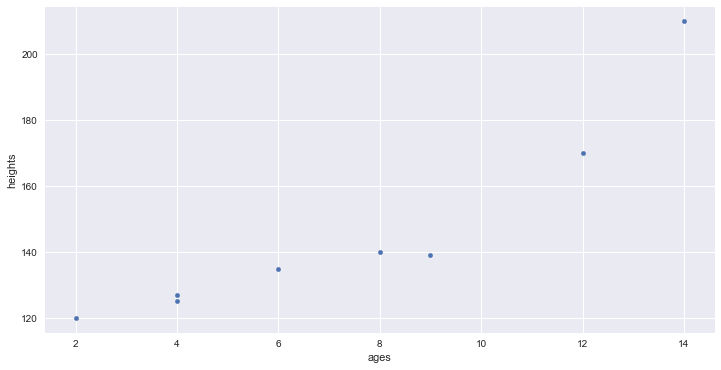

In [3]:
quick_scatterplot(data_metric)

Clearly, the older kids are, the taller they get, with some exceptions here and there. 

## Covariance 

For all practical purposes covariance is, quite simply, a measure of "how much" two variables change together.

It's expression is given by the following: 

$$ cov = \frac{\sum{(X - X_{avg})(Y - Y_{avg})}}{n-1} $$

The top part of this equasion can be tought about visually by drawing the following: 
1. A cross in the $(X_{avg}, Y_{avg})$ point   
2. Squares between the mean (age, height) point, and the observed (age, height) points. 

I'll draw one here for the kid with $(age=12, height=170)$ 

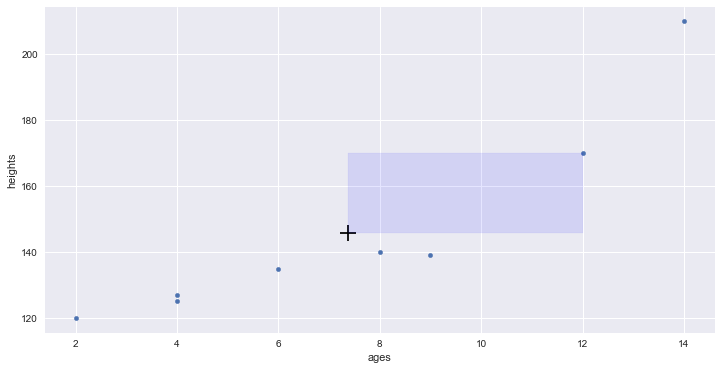

In [4]:
quick_scatterplot(data_metric, plot_center=True, plot_squares=6)

By observing the equation, we can notice that some "squares" will count negatively to the covariance (for instance the kid with $(age=9, height=139)$, because 
$$(9-7.375) * (139 - 145.75) \approx -11 $$
(notice that `Age_avg=7.375`, `Height_avg=145.75`) 

We will represent these in red: 

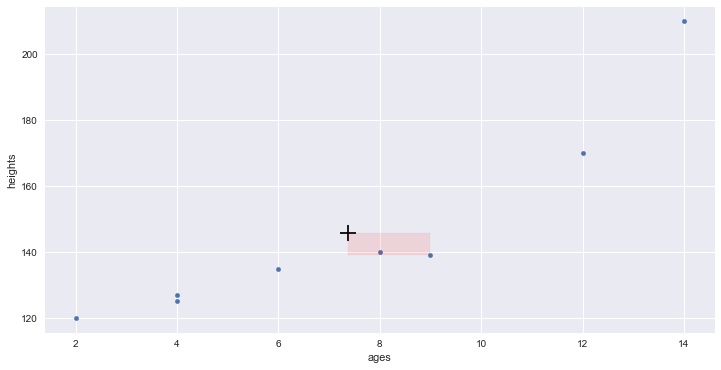

In [5]:
quick_scatterplot(data_metric, plot_center=True, plot_squares=5)

So a simple visual intuition for covariance is "the blue, minus the red":

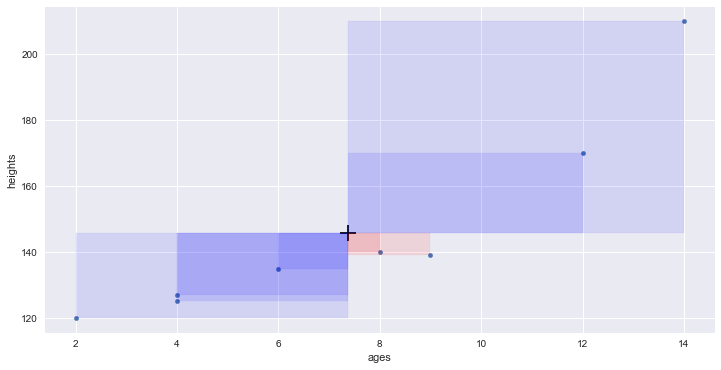

In [6]:
quick_scatterplot(data_metric, plot_center=True, plot_squares='all')

## Calculating covariance by hand 
Great! Now that we have a visual intuition, we can simply calculate this by hand: 

Quick reminder of the formula: 
$$ cov = \frac{\sum{(X - X_{avg})(Y - Y_{avg})}}{n-1} $$

In [7]:
# subtract the mean age from each of the ages 
data_metric['ages - mean_age'] = data_metric['ages'] - data_metric['ages'].mean()
# subtract the mean height from each of the heights 
data_metric['heights - mean_height'] = data_metric['heights'] - data_metric['heights'].mean()
# get the product between the two columns we just calculated 
data_metric['product of differences'] = (data_metric['ages - mean_age'] * data_metric['heights - mean_height'])

In [8]:
data_metric.head()

,ages,heights,ages - mean_age,heights - mean_height,product of differences
0,2,120,-5.375,-25.75,138.40625
1,4,125,-3.375,-20.75,70.03125
2,4,127,-3.375,-18.75,63.28125
3,6,135,-1.375,-10.75,14.78125
4,8,140,0.625,-5.75,-3.59375


Alright, so to calculate the top of the fraction we just need to sum the last column

In [9]:
top_of_fraction = data_metric['product of differences'].sum()

The bottom half is `n-1`, where `n` is the number of rows. We have the [`.shape`](http://pandas.pydata.org/pandas-docs/version/0.17.0/generated/pandas.DataFrame.shape.html) command to get that! 

In [10]:
covariance_by_hand = top_of_fraction / (data_metric.shape[0] - 1)

So how much is our co-variance, calculated by hand? 

In [11]:
print('Covariance by hand = %0.2f' % covariance_by_hand)

Covariance by hand = 115.68


Well that was boring! Let's just use 1 line of pandas instead: 

In [12]:
covariance_with_pandas = data_metric['ages'].cov(data_metric['heights'])

In [13]:
print('Covariance with Pandas = %0.2f' % covariance_with_pandas)

Covariance with Pandas = 115.68


### Quick summary of what we did: 

Now let us consider the units here. We did some weird things: 
1. Subtracted the mean height (cm) from each height, meaning that our column A was in cm 
2. Subtracted the mean age (years) from each age, meaning that our column B was in years
3. We then multiplied these two, making our column C be in the odd unit of `cm.years`
4. Now we summed over the observations, keeping the units (`cm.years`) 
5. We finally divided by the number of observations (minus one), so the unit is still `cm.years`

What this means in practice, is that if your boss asked you how the heights and ages were related, using covariance would lead to the akward answer:

![poor answer](https://i.imgflip.com/27xd7y.jpg)

Which is perfectly correct, but not particularly informative. For one thing, it depende on the magnitude of the variables, which is counter-intuitive. If we were measuring heights in inches instead of centimeters, would the relationship become weaker? Because the variance, as we have just noticed, would certainly change!  

The problem here is that the metric is giving you an idea of **_the extent to which the variables change together_**, which sounds good, but is dependent on the magnitude of the variables themselves, and generally not actually what we want. 

More often than not, we want to answer the question **_how strong is the relationship between these two variables?_**. And to answer that question, as you might have guessed, we have our old friend, correlation. 

## Why use correlation 

Let us think about this. The covariance for our age and heights problem was `115.68 cm.years`. 

We don't like this "`cm.years`" nonsense, and want a measure that will hold even if we are working with feet instead of centimeters.  
(_Note: 1ft ~ 30.48cm in Freedom Units <sup>TM</sup>_) 

In [14]:
# The same dataset, but now with the heights in feet, instead of centimeters 
data_freedom_units = get_heights_data_freedom_units()
# Let's take a look 
data_freedom_units.head(5)

,ages,heights
0,2,3.937008
1,4,4.101050
2,4,4.166667
3,6,4.429134
4,8,4.593176


Now that the dataset is in feet, our covariance will go down, because the magnitude of our heights will be on a smaller scale. Can you spot that in the expression? 

$$ cov = \frac{\sum{(Height_i - Height_{mean})(Age_i - Age_{mean})}}{n-1} $$

Let's calculate the covariance in metric, and in freedom units, and print it: 

In [15]:
# calculate the covariance in the metric dataset 
covariance_in_metric = data_metric['ages'].cov(data_metric['heights'])

# calculate the covariance in the freedom units dataset 
covariance_in_freedom_units = data_freedom_units['ages'].cov(
    data_freedom_units['heights'])

print('Covariance using centimeters:                      %0.02f (cm.years)  ' % covariance_in_metric)
print('Covariance when using feet instead of centimeters: %0.02f   (ft.years)' % covariance_in_freedom_units)

Covariance using centimeters:                      115.68 (cm.years)  
Covariance when using feet instead of centimeters: 3.80   (ft.years)


So this kind of sucks. Depending on how we measure it, we get different "amount of relationship", which is very counter intuitive. 

![](https://i.imgflip.com/27xlme.jpg)

## Correlation 

Correlation is covariance's prettier, cooler, and more successfull sister. 

There are multiple reasons for this 
> 1. Correlation is adimensional (unit free), so it's easier to think about (none of this "cm.years" nonsense) 
> 2. The value of correlation takes place between -1 and +1, while covariance lies between -∞ and +∞.
> 3. Correlation is not affected by the change in scale, while covariance is. 

As you grow older, you will likely forget about covariance and remember only correlation, in the same way that everyone remembers Bill Gates and no-one remembers Paul Allen (in this analogy, Bill Gates is the "cool one"). 

But before you toss covariance into the dustbin of your mind, remember only this: 

> Correlation is just normalized covariance

Normalized by what, I head you ask? By variance! 

$$ correlation = \frac{covariance(X, Y)}{\sqrt{Var(X) * Var(Y)}} $$

Remember that when the heights turned to feet, our covariance went down? Well, the $\sqrt{Var(X) * Var(Y)}$ term in the correlation comes to the rescue here, because it will also become proportionately smaller. 

Let's try: 

In [16]:
# get the variance of the ages (same for both datasets)
variance_ages = data_metric['ages'].var()
# get the variance of the heights in cm 
variance_heights_cm = data_metric['heights'].var()
# get the variance of the heights in feet 
variance_heights_ft = data_freedom_units['heights'].var()

# print the results 
print('In metric system:')
print('Variance of ages:    %0.02f   (years**2)' % variance_ages)
print('Variance of heights: %0.02f  (cm**2)' % variance_heights_cm)
print('\nIn freedom units')
print('Variance of ages:    %0.02f   (years**2)' % variance_ages)
print('Variance of heights: %0.02f    (ft**2)' % variance_heights_ft)

In metric system:
Variance of ages:    17.41   (years**2)
Variance of heights: 907.93  (cm**2)

In freedom units
Variance of ages:    17.41   (years**2)
Variance of heights: 0.98    (ft**2)


So while the covariance increased, the variance of the heights also increased, which will offset each other, and allow correlation to be independent of how we measure the heights! 

Now in the meantime, you've probably noticed the metrics of the variance, leading to the question ...

![square feet](https://i.imgflip.com/27xfyc.jpg)

That's just the way Variance works. It calculated how much your variable is "scattered", but the units aren't intuitive (which is why we generally prefer standard deviation). 

However, using variance gives us a super cool propriety, which is that correlation has no units! 

$$ correlation = \frac{covariance}{\sqrt{Var(X) * Var(Y)}}$$

Notice the units: 

$$\frac{ ... ft.years}{\sqrt{( ... years^{2}) * ( ... ft^{2}})}  \Leftrightarrow  \frac{... ft.years}{(\sqrt{... (ft.years)^{2}})} \Leftrightarrow \frac{ ... ft.years}{... ft.years} \Leftrightarrow VictoryIsMine! $$ 

There only remains to do the satisfying thing, in Pandas: 

In [17]:
# calculate the correlation in the metric dataset, in Pandas
correlation_in_metric = data_metric['heights'].corr(data_metric['ages'])

# calculate the correlation in the freedom units dataset, in Pandas
correlation_in_freedom_units = data_freedom_units['heights'].corr(data_freedom_units['ages'])

# print results 
print('Correlation in metric system:            %0.2f' % correlation_in_metric)
print('Correlation in imperial (freedom) units: %0.2f' % correlation_in_freedom_units)

Correlation in metric system:            0.92
Correlation in imperial (freedom) units: 0.92


Ye-haw. 

# Pearson vs Spearman correlation 

Confession time! 

![](https://i.imgflip.com/27xm3b.jpg)

There are two types of correlation, Pearson, and Spearman. However, Pearson is so common, that when people just say _"correlation"_ you can pretty much assume that is what they mean. 

### Spearman correlation 

Spearman correlation is "Rank correlation". The easiest way to think of this, is to forget about the actual values, and consider only their relative positions (ranks). 

To observe this, we can use Pandas's convenient `rank` function: 

In [18]:
# I'll get the dataset again (as we altered it in the explanation above)
data_metric = get_heights_data_metric()

Original: 

In [19]:
data_metric

,ages,heights
0,2,120
1,4,125
2,4,127
3,6,135
4,8,140
5,9,139
6,12,170
7,14,210


Rank: 

In [20]:
data_metric.rank()

,ages,heights
0,1.0,1.0
1,2.5,2.0
2,2.5,3.0
3,4.0,4.0
4,5.0,6.0
5,6.0,5.0
6,7.0,7.0
7,8.0,8.0


So the youngest age become `1`, the smallest height became `1`, and the others took their "rank" position. When there is a tie (there is more than one 2-year-old kid in this dataset) they both take position `2.5`, and no-one becomes `2` or `3`. Other than that, it's very simple. 

Let's plot the rank positions: 

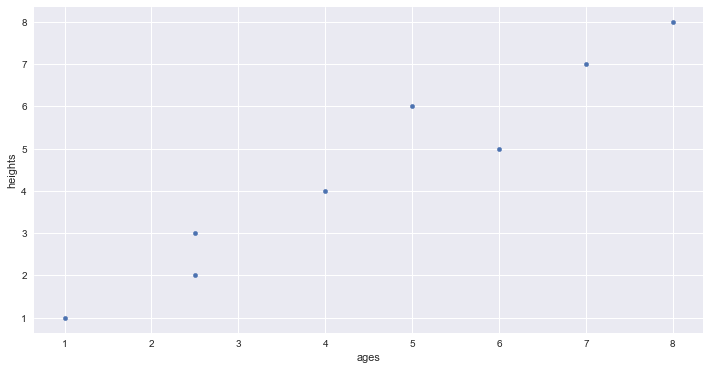

In [21]:
quick_scatterplot(data_metric.rank())

The pearson correlation is simply the correlation between the rank coefficients. Or, as I like to think of it, the correlation between the "positions on the podium" for height, and "positions on the podium" for age. 

To calculate spearman correlation, we can use the rank data:

In [22]:
ranked_data = data_metric.rank()
ranked_data['ages'].corr(ranked_data['heights'])

0.97007727214973971

However, because Pandas is made for lazy people, we can also just use the argument `method=spearman`

In [23]:
data_metric['ages'].corr(data_metric['heights'], method='spearman')

0.97007727214973982

### Why use Spearman at all

Let's say we are interested in knowing if two stocks generally grow together, and they exhibit the following pattern:

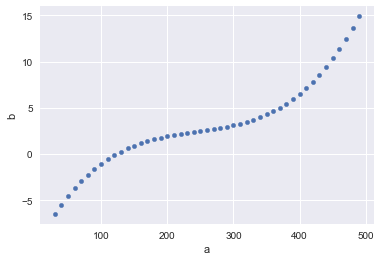

In [24]:
example = get_data_for_spearman()
example.plot(kind='scatter', x='a', y='b')

By looking at them, we can see that while the slope changes every once in a while, the rank correlation is 100% (when one goes up, so does the other). 

In [25]:
print('Pearson correlation: %0.02f' % example['a'].corr(example['b']))
print('Spearman correlation: %0.02f' % example['a'].corr(example['b'], method='spearman'))

Pearson correlation: 0.95
Spearman correlation: 1.00


# The correlation matrix 

So far we've been looking at two variables at the time. Now, let's get a slightly more interesting dataset, with some information about houses: 

In [26]:
data = pd.read_csv('data/HousingData.csv')

In [27]:
data.head()

,crime,industrial,river,buildings_age,roads_quality,school_quality,taxes,poverty,house_price,number_of_rooms,pollution
0,0.00632,2.31,0,65.2,1,15.3,296,4.98,24.0,6.575,0.538
1,0.02731,7.07,0,78.9,2,17.8,242,9.14,21.6,6.421,0.469
2,0.03237,2.18,0,45.8,3,18.7,222,2.94,33.4,6.998,0.458
3,0.06905,2.18,0,54.2,3,18.7,222,5.33,36.2,7.147,0.458
4,0.08829,7.87,0,66.6,5,15.2,311,12.43,22.9,6.012,0.524


Intuitively, some of these things should be correlated. 
* Housing prices and poverty?
* Industrial activity and pollution? 
* Crime and school quality? 

Instead of going one by one and making all the pairs, we can quickly compute a correlation matrix, using pandas' `.corr` method. 

In [28]:
data.corr()

,crime,industrial,river,buildings_age,roads_quality,school_quality,taxes,poverty,house_price,number_of_rooms,pollution
crime,1.000000,0.422228,-0.041195,0.379034,0.666636,0.313409,0.617081,0.532077,-0.407454,-0.310180,0.463001
industrial,0.422228,1.000000,0.037496,0.638378,0.569779,0.391087,0.708313,0.614155,-0.473932,-0.440365,0.750087
river,-0.041195,0.037496,1.000000,0.068286,0.007714,-0.125067,-0.021826,-0.050055,0.204390,0.112251,0.080275
buildings_age,0.379034,0.638378,0.068286,1.000000,0.447380,0.259293,0.511893,0.588834,-0.358888,-0.248573,0.736000
roads_quality,0.666636,0.569779,0.007714,0.447380,1.000000,0.470849,0.903562,0.484568,-0.352251,-0.272783,0.612180
school_quality,0.313409,0.391087,-0.125067,0.259293,0.470849,1.000000,0.467437,0.374802,-0.481376,-0.366927,0.192513
taxes,0.617081,0.708313,-0.021826,0.511893,0.903562,0.467437,1.000000,0.544485,-0.448078,-0.356987,0.670722
poverty,0.532077,0.614155,-0.050055,0.588834,0.484568,0.374802,0.544485,1.000000,-0.738600,-0.615747,0.598874
house_price,-0.407454,-0.473932,0.204390,-0.358888,-0.352251,-0.481376,-0.448078,-0.738600,1.000000,0.689598,-0.413054
number_of_rooms,-0.310180,-0.440365,0.112251,-0.248573,-0.272783,-0.366927,-0.356987,-0.615747,0.689598,1.000000,-0.338515


This is interesting, and we can see "everything against everything". In practice, this is one of those cases where nothing beats a little visualization. 

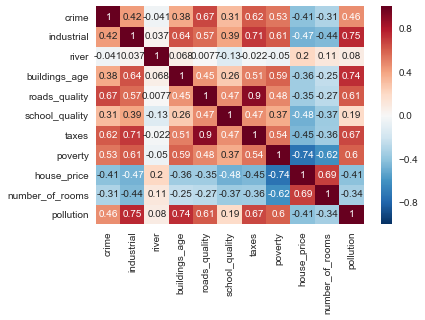

In [29]:
sns.heatmap(data.corr(), annot=True)

I'll let your eyes wonder over this beautiful cascade of interesting information. Pandas is amazing. 

# Spurious correlations 

A well known, but very often overlooked fact is that **CORRELATION DOES NOT IMPLY CAUSATION**

![](https://ic.pics.livejournal.com/mi3ch/983718/4592053/4592053_original.png)

_Image Source: [spurious correlations](http://www.tylervigen.com/spurious-correlations), visit the website to see more of these_

The temptation to use correlation is often overwhelming. Common arguments include: 
> _"Maybe it's not causation, but for practical purposes I can use it anyway"_

> _"Well, we need to check the p-values, sure, but then it's safe, right?"_

As a data scientist, it is one of your primary responsibilities to be skeptical. Part of that comes from understanding that data, if tortured, will tell you whatever you want it to. 

For instance, if you dive into a dataset of stocks, and look for really strong correlations, you **will** find them. That in no way means you are going to become ritch. The likelyhood that you wouldn't find anything, given the number of tries you are making, is very, very small, and therefore your "expected" status is... to find something. 

Skepticism as a way of thinking is (or should be) at the core of healthy data science. Following the scientific method, and searching for evidence that leads you to refute the null hypothesis that your theory is wrong (your starting point must be _"I'm probably wrong, unless I find overwhelming evidence"_) will protect you against falling into the giant trap that is the allure of the siren of correlation. 

# Observational vs Experimental data 

One crucial concept to keep in mind is the one of experimental vs observational data. 

The fundamental difference is that experimental data was collected in a controlled experiment, by the researcher, while trying to control for as many external variables as possible, and using randomness to assign control groups, whereas observational data is simply collected by observing events. 

Observational data is obviously a lot more error prone. 


## Why is this important? 


Consider [this study](https://www.nature.com/articles/20094), which found its way into Nature (one of the most prestigious magazines) in the late 90s. 

The abstract reads: 
> We have looked at the effects of light exposure on vision, and **find a strong association between myopia and night-time ambient light exposure during sleep in children** before they reach two years of age.

The study was done by taking data from children who had slept with night lights, and others who hadn't. These children were not selected into randomized groups and made to sleep with the lights on or off, they were simply observations from children who had already grown up, and either developed myopia, or not. 

The study found overwhelming evidence that the children who had slept with the lights on, had develoepd myopia in a significantly higher proportion, and therefore the published article finds that "there is a strong association" (generally correlation). 

The experiment did not take one tiny detail into account. It turns out that... 

![](https://i.imgflip.com/27xuct.jpg)



In other words, because myopia is genetic, the children of myopic children (who would then go on to develop myopia because of their parents condition) tended to sleep more often with the lights on. This is what is called a **confouding variable**. 

![](https://explorable.com/sites/default/files/documents/third-variable.png)

The use of observational data didn't allow for a control group, and therefore they found overwhelming evidence of... nothing much. 

### What is there to be done? 

Naturally, this is not always avoidable. Maybe a cohort of children (of both myopic and non-myopic parents) could have been randomly assigned to sleep with lights either on or off. However, as if obvious, experimental data is much harder to collect, and would be a lot more intrusive on parents and children. 

When using either experimental or observational data, there are a few things that we must always keep in mind: 

> 1. Correlation is not causation 
> 2. Data, dispite its reputation to the contrary, lies. 

# To learn more (optional) 

#### Experimental vs observational studies 
* [Short presentation with good intuitive examples](https://stats.stackexchange.com/questions/13300/difference-between-experimental-data-and-observational-data)
* [Discussion on stackexchange](https://stats.stackexchange.com/questions/13300/difference-between-experimental-data-and-observational-data)